In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
idx = pd.IndexSlice

import datetime as dt
from datetime import date
from datetime import timedelta
import dateutil.parser as dup

%aimport trans.data
%aimport trans.gtrans
%aimport trans.reg
%aimport trans.regpipe

from trans.data import GetData
gd = GetData()
from trans.gtrans import *
from trans.reg import Reg, RegAttr
from trans.regpipe import RegPipe

## Memorialize: a switch that causes repeatability by fixing the end date, etc.  
## It then writes is output to a "verify_" file for regression testing


In [3]:
Memorialize = False

In [4]:
today = dt.datetime.combine( date.today(), dt.time.min)
if Memorialize:
    today = dup.parse("03/09/2018")
    
end_fixed = today
today

start = dup.parse("01/01/2000")
start

datetime.datetime(2018, 5, 10, 0, 0)

datetime.datetime(2000, 1, 1, 0, 0)

In [5]:
gd = GetData()
univ = gd.existing()
univ.sort()

len(univ)

1118

In [6]:
sectors =  { 
    "Consumer Discretionary": "XLY",
    "Consumer Staples": "XLP",
    "Energy": "XLE",
    "Financial": "XLF",
    "Health": "XLV",
    "Industrial": "XLI", 
    "Materials" : "XLB",
    "Real Estate": "XLRE",
    "Technology": "XLK", 
    "Telecom": "XTL",
    "Utilities": "XLU"
}
   

In [7]:
sector_tickers = list( sectors.values() )

In [8]:
sector_tickers

['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XTL', 'XLU']

## Download data

In [9]:
get = False
if get:
    changed_tickers = gd.get_data( sector_tickers, start, today )
    len(changed_tickers)
    list( set(sector_tickers) - set(changed_tickers))

## Assemble data (already downloaded) into DataFrame
- Note: The index will be a DateTime already, no need to convert from string. No need for DatetimeIndexTransformer
- Note: the index will be restricted to dates from SPY, no need for RestrictToCalendarColTransformer

In [10]:
price_df = GetDataTransformer(sector_tickers, cal_ticker="SPY").fit_transform( pd.DataFrame())
if Memorialize:
    price_df = price_df.loc[:end_fixed,:]
    
price_df.shape

DEPRECATED in favor of GetDataProviderTransformer.


/home/ubuntu/Notebooks/trans/data.py:415: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:837: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  trans.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:838: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  trans.sortlevel(axis=1, inplace=True)


(4594, 72)

In [11]:
price_df.index.min()
price_df.index.max()
price_df.loc[:, idx["Adj Close",:]].shape

if Memorialize:
    gd.save_data( price_df.loc[:, idx["Adj Close",:]], "verify_sectors_raw_df.pkl")

Timestamp('2000-01-03 00:00:00')

Timestamp('2018-04-06 00:00:00')

(4594, 12)

## Compute returns

In [12]:
type(price_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [13]:
pipe_pct   = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=False),
                           pctTrans,
                           GenRenameAttrsTransformer(lambda col: "Pct", level=0)
                          )
pct_df = pipe_pct.fit_transform(price_df)
pct_df.tail()

PANDA version > 0.20.0


Pct                                                    \
                 SPY       XLB       XLE       XLF       XLI       XLK   
Dt                                                                       
2018-04-02 -0.021585 -0.021777 -0.020027 -0.022126 -0.020595 -0.023846   
2018-04-03  0.001631 -0.002693 -0.004995  0.002226 -0.000275 -0.005637   
2018-04-04  0.021986  0.023582  0.025103  0.022206  0.018559  0.029764   
2018-04-05  0.007892  0.018642  0.017958  0.007965  0.010123  0.004129   
2018-04-06 -0.022361 -0.024344 -0.018078 -0.024066 -0.027659 -0.024520   

                                                                        
                 XLP      XLRE       XLU       XLV       XLY       XTL  
Dt                                                                      
2018-04-02 -0.024511 -0.012226 -0.007718 -0.022727 -0.028236 -0.019454  
2018-04-03  0.002532 -0.000489  0.000299 -0.000126  0.000203  0.007551  
2018-04-04  0.026423  0.015806  0.005284  0.029796  0.031082  0.015724  
2018-04-05  0.002461  0.000962  0.007933 -0.000733  0.013398  0.007378  
2018-04-06 -0.010196 -0.010256 -0.007871 -0.024068 -0.021289 -0.013177

In [14]:
if Memorialize:
    gd.save_data( pct_df, "verify_sectors_pct_df.pkl")

## Alternate way of creating Returns: drop attribute and re-add

In [15]:
pipe_pct   = make_pipeline(GenSelectAttrsTransformer(['Adj Close'], dropSingle=True), 
                           # RestrictToCalendarColTransformer( "SPY" ),
                           pctTrans,
                           # DatetimeIndexTransformer("Dt"),
                           # RestrictToNonNullTransformer("all"),
                           AddAttrTransformer('Pct')
                      )
pct_df = pipe_pct.fit_transform(price_df)
pct_df.shape
pct_df.tail()

PANDA version > 0.20.0


(4594, 12)

Pct                                                    \
                 SPY       XLB       XLE       XLF       XLI       XLK   
Dt                                                                       
2018-04-02 -0.021585 -0.021777 -0.020027 -0.022126 -0.020595 -0.023846   
2018-04-03  0.001631 -0.002693 -0.004995  0.002226 -0.000275 -0.005637   
2018-04-04  0.021986  0.023582  0.025103  0.022206  0.018559  0.029764   
2018-04-05  0.007892  0.018642  0.017958  0.007965  0.010123  0.004129   
2018-04-06 -0.022361 -0.024344 -0.018078 -0.024066 -0.027659 -0.024520   

                                                                        
                 XLP      XLRE       XLU       XLV       XLY       XTL  
Dt                                                                      
2018-04-02 -0.024511 -0.012226 -0.007718 -0.022727 -0.028236 -0.019454  
2018-04-03  0.002532 -0.000489  0.000299 -0.000126  0.000203  0.007551  
2018-04-04  0.026423  0.015806  0.005284  0.029796  0.031082  0.015724  
2018-04-05  0.002461  0.000962  0.007933 -0.000733  0.013398  0.007378  
2018-04-06 -0.010196 -0.010256 -0.007871 -0.024068 -0.021289 -0.013177

In [16]:
from dateutil.relativedelta import relativedelta, FR
lastFriday = today + relativedelta(weekday=FR(-1))

In [17]:
import dateutil.parser as dup
import dateutil.relativedelta as rd

regWindow = rd.relativedelta(months=+6)
regStep   = rd.relativedelta(weeks=+4)

regStart = dup.parse("01/01/2000")
regEnd = lastFriday
if Memorialize:
    regEnd   = dup.parse("12/29/2017")
# regEnd   = dup.parse("02/28/2018")

In [18]:
regParams = { "start": regStart, "end": regEnd, "window": regWindow, "step": regStep }
if Memorialize:
    gd.save_data( regParams, "verify_regParams.pkl")

## Compute the model: 
$Return_{sector ticker} = \beta_0 + \beta * Return_{SPY} + \epsilon$

In [19]:
rp = RegPipe( pct_df )
rp.indCols( [ idx["Pct", "SPY"] ] )
rp.regress( regStart, regEnd, regWindow, regStep)

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit: the following columns have naN:  ['XLRE']
Fit:

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)


In [20]:
rp.beta_df.shape
rp.beta_df.tail()

(233, 22)

Beta 0                                                    \
                     XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                           
2018-01-12 -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.000020   
2018-02-09  1.478549e-04 -0.000106  0.000222  0.000123  0.000176 -0.000440   
2018-03-09 -1.044846e-04 -0.000357  0.000602  0.000115  0.000374 -0.000667   
2018-04-06 -3.585119e-04 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2018-05-04 -4.249191e-04 -0.000185  0.000098  0.000087  0.000028 -0.000117   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2018-01-12 -0.000391 -0.000167 -0.000268  0.000183    ...     0.762249   
2018-02-09 -0.000733 -0.000795 -0.000154  0.000414    ...     0.920964   
2018-03-09 -0.001026 -0.001155 -0.000567  0.000513    ...     0.965968   
2018-04-06 -0.000394 -0.000438 -0.000457  0.000586    ...     0.982967   
2018-05-04 -0.000494 -0.000789 -0.000251  0.000847    ...     0.990824   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2018-01-12  1.101864  1.058393  1.354621  0.429370  0.357483  0.067103   
2018-02-09  1.115798  1.015323  1.220437  0.619450  0.566114  0.244795   
2018-03-09  1.095696  1.021995  1.185922  0.669893  0.594819  0.378279   
2018-04-06  1.099590  1.051941  1.184890  0.658753  0.532844  0.324006   
2018-05-04  1.105126  1.055002  1.172966  0.669890  0.542776  0.320119   

                                          
                 XLV       XLY       XTL  
Dt                                        
2018-01-12  0.933367  0.999419  1.181681  
2018-02-09  0.941997  0.912110  0.837640  
2018-03-09  0.950807  0.894230  0.845706  
2018-04-06  0.967147  0.961264  0.840217  
2018-05-04  0.975103  0.955404  0.843575  

[5 rows x 22 columns]

## Compute residuals:
 - For residual, don't roll beta: the date of the beta is the last date of the regression window
 - Fill the beta backwards, so the in-sample beta is applied

In [21]:
rollAmount = 0
fillMethod = "bfill"

rp.attrib_setup(pct_df, rp.beta_df, rollAmount, fillMethod)

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


In [22]:
rp.attrib()

rp.retAttr_df.shape
rp.retAttr_df.loc[:"2017-12-29",:].tail()

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


(4603, 44)

Contrib from 1                                                   \
                      XLB       XLE       XLF       XLI       XLK      XLP   
Dt                                                                           
2017-12-22  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-26  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-27  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-28  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   
2017-12-29  -1.435423e-07  0.000736  0.000138  0.000078 -0.000071 -0.00002   

                                                      ...    Predicted  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-12-22 -0.000391 -0.000167 -0.000268  0.000183    ...     0.000537   
2017-12-26 -0.000391 -0.000167 -0.000268  0.000183    ...    -0.000175   
2017-12-27 -0.000391 -0.000167 -0.000268  0.000183    ...     0.001107   
2017-12-28 -0.000391 -0.000167 -0.000268  0.000183    ...     0.002305   
2017-12-29 -0.000391 -0.000167 -0.000268  0.000183    ...    -0.002138   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-12-22 -0.000151 -0.000199 -0.000425 -0.000132 -0.000485 -0.000185   
2017-12-26 -0.001180 -0.001188 -0.001691 -0.000534 -0.000819 -0.000248   
2017-12-27  0.000674  0.000593  0.000588  0.000189 -0.000218 -0.000135   
2017-12-28  0.002405  0.002255  0.002716  0.000863  0.000344 -0.000029   
2017-12-29 -0.004017 -0.003913 -0.005178 -0.001639 -0.001739 -0.000420   

                                          
                 XLV       XLY       XTL  
Dt                                        
2017-12-22 -0.000512 -0.000079 -0.001479  
2017-12-26 -0.001384 -0.001013 -0.002583  
2017-12-27  0.000186  0.000669 -0.000595  
2017-12-28  0.001652  0.002239  0.001262  
2017-12-29 -0.003787 -0.003586 -0.005625  

[5 rows x 44 columns]

## Demonstrate a non-rolling

In [23]:
regStarts = regEnd - regWindow + timedelta(days=1)

pct_dfs = pct_df.loc[ regStarts:regEnd,:]

rps = RegPipe( pct_dfs )
rps.indCols( [ idx["Pct", "SPY"] ] )
rps.regressSingle()

rps.beta_df.shape
rps.beta_df.tail()

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)


(1, 22)

Beta 0                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2018-04-06 -0.000425 -0.000185  0.000098  0.000087  0.000028 -0.000117   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2018-04-06 -0.000494 -0.000789 -0.000251  0.000847    ...     0.990824   

                                                                       \
                 XLF       XLI       XLK      XLP      XLRE       XLU   
Dt                                                                      
2018-04-06  1.105126  1.055002  1.172966  0.66989  0.542776  0.320119   

                                          
                 XLV       XLY       XTL  
Dt                                        
2018-04-06  0.975103  0.955404  0.843575  

[1 rows x 22 columns]

In [24]:
if Memorialize:
    gd.save_data( rps.beta_df, "verify_beta_df.pkl")

In [25]:
rollAmount = 0
fillMethod = "bfill"

rps.attrib_setup(pct_dfs, rps.beta_df, rollAmount, fillMethod)
rps.attrib()

rps.retAttr_df.shape
rps.retAttr_df.loc[:"2017-12-29",:].tail()

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


(104, 44)

Contrib from 1                                                    \
                      XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                            
2017-12-22      -0.000425 -0.000185  0.000098  0.000087  0.000028 -0.000117   
2017-12-26      -0.000425 -0.000185  0.000098  0.000087  0.000028 -0.000117   
2017-12-27      -0.000425 -0.000185  0.000098  0.000087  0.000028 -0.000117   
2017-12-28      -0.000425 -0.000185  0.000098  0.000087  0.000028 -0.000117   
2017-12-29      -0.000425 -0.000185  0.000098  0.000087  0.000028 -0.000117   

                                                      ...    Predicted  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-12-22 -0.000494 -0.000789 -0.000251  0.000847    ...    -0.000444   
2017-12-26 -0.000494 -0.000789 -0.000251  0.000847    ...    -0.001370   
2017-12-27 -0.000494 -0.000789 -0.000251  0.000847    ...     0.000298   
2017-12-28 -0.000494 -0.000789 -0.000251  0.000847    ...     0.001854   
2017-12-29 -0.000494 -0.000789 -0.000251  0.000847    ...    -0.003920   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-12-22 -0.000191 -0.000189 -0.000278 -0.000292 -0.000636 -0.000873   
2017-12-26 -0.001224 -0.001175 -0.001375 -0.000919 -0.001143 -0.001172   
2017-12-27  0.000636  0.000601  0.000599  0.000209 -0.000230 -0.000634   
2017-12-28  0.002372  0.002258  0.002442  0.001261  0.000623 -0.000131   
2017-12-29 -0.004069 -0.003891 -0.004394 -0.002643 -0.002541 -0.001997   

                                          
                 XLV       XLY       XTL  
Dt                                        
2017-12-22 -0.000506  0.000597  0.000159  
2017-12-26 -0.001417 -0.000296 -0.000630  
2017-12-27  0.000224  0.001312  0.000790  
2017-12-28  0.001755  0.002813  0.002115  
2017-12-29 -0.003928 -0.002755 -0.002801  

[5 rows x 44 columns]

In [26]:
sector_residuals = rps.retAttr_df.loc[:, idx["Error",:]]
sector_residuals.tail()

Error                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2018-04-02  0.001235  0.001544  0.001630  0.002090  0.001444 -0.009934   
2018-04-03 -0.003975 -0.006427  0.000325 -0.002083 -0.007579  0.001557   
2018-04-04  0.001000  0.003503 -0.002190 -0.004723  0.003947  0.011812   
2018-04-05  0.010808  0.010323 -0.000854  0.001709 -0.005156 -0.002709   
2018-04-06 -0.000519  0.004262  0.000548 -0.004155  0.001680  0.004900   

                                                              
                XLRE       XLU       XLV       XLY       XTL  
Dt                                                            
2018-04-02 -0.000017 -0.000019 -0.001429 -0.008461 -0.001625  
2018-04-03 -0.000880  0.000566 -0.001465 -0.002203  0.005796  
2018-04-04  0.004366 -0.000965  0.008609  0.009229 -0.003202  
2018-04-05 -0.002827  0.006197 -0.008177  0.005010  0.000342  
2018-04-06  0.002375  0.000077 -0.002013 -0.000772  0.005307

In [27]:
if Memorialize:
    gd.save_data(sector_residuals, "sector_residuals.pkl")

In [28]:
resStart = dup.parse("01/01/2016")

## OBSOLETE, replaced by trans.stack_residual

In [29]:
from trans.stack import Stack
%aimport trans.stack

s = Stack(pct_df)
stack = s.repeated(resStart, regEnd, regWindow, regStep)

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

DEPRECATED: <class 'trans.regpipe.RegPipe'>:__init__ called w/o "attr" arg., defaulting to Pct.
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


In [30]:
for stk in stack :
    suffix = stk[0].strftime("%Y%m%d")
    data = stk[1]
    
    if Memorialize:
        gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))
    
             

## Residual stack

In [31]:
%aimport trans.stacked.residual
from trans.stacked.residual import Residual

rstack = Residual(indCols=[ idx["Pct", "SPY"] ], debug=True)
rstack.init(df=pct_df, start=resStart, end=regEnd, window=regWindow, step=regStep)
resid_stack = rstack.repeated()
rstack.done()

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


DEPRECATED: <class 'trans.stacked.residual.Residual'>:__init__ called w/o "attr" arg., defaulting to Pct.
nextChunk for period 2017-11-05 00:00:00 to 2018-05-04 00:00:00 shape: (104, 12)
repeated: chunk label 2018-05-04 00:00:00 with shape (104, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'X

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

rps retAttr_df:             Contrib from 1                                                    \
                      XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                            
2018-04-02      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2018-04-03      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2018-04-04      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2018-04-05      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   
2018-04-06      -0.000359 -0.000207  0.000074 -0.000073  0.000336 -0.000281   

                                                      ...    Predicted  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2018-04-02 -0.000394 -0.000438 -0.000457  0.000586    ...    -0.021424   
2018-04-03 -0.000394 -0.000438 -0.000457  0.000586    

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
rps beta_df:                Beta 0                                                   \
                 XLB       XLE       XLF       XLI       XLK      XLP   
Dt                                                                      
2018-02-09  0.000148 -0.000106  0.000222  0.000123  0.000176 -0.00044   

                                                     ...       Beta 1  \
                XLRE       XLU       XLV       XLY   ...          XLE   
Dt                                                   ...                
2018-02-09 -0.000733 -0.000795 -0.000154  0.000414   ...     0.920964   

                                                                       \
                 XLF       XLI       XLK      XLP      XLRE       XLU   
Dt                                                                      
2018-02-09  1.115798  1.015323  1.220437  0.61945  0.566114  0.244795   

                   

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
rps beta_df:                Beta 0                                                           \
                 XLB     XLE       XLF       XLI      XLK       XLP      XLRE   
Dt                                                                              
2017-12-15 -0.000014  0.0001  0.000306 -0.000108  0.00012 -0.000294 -0.000104   

                                           ...       Beta 1            \
                 XLU       XLV      XLY    ...          XLE       XLF   
Dt                                         ...                          
2017-12-15  0.000171 -0.000066 -0.00008    ...     0.595558  1.020384   

                                                                      \
                XLI       XLK   

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

              Beta 0                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2017-10-20  0.000125 -0.000282  0.000142  0.000167  0.000085 -0.000467   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-10-20 -0.000141  0.000526  0.000385 -0.000462    ...     0.552528   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-10-20  1.239998  1.003725  1.376155  0.522774  0.446882  0.140633   

                                          
                 XLV       XLY       XTL  
Dt                     

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

              Beta 0                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2017-08-25 -0.000024 -0.001069 -0.000239 -0.000099  0.000385 -0.000138   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-08-25  0.000143  0.000631  0.000226 -0.000117    ...     0.797035   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2017-08-25  1.350062  1.119566  1.254503  0.475669  0.485934  0.092089   

                                          
                 XLV       XLY       XTL  
Dt                     

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i


rps retAttr_df:             Contrib from 1                                                  \
                      XLB      XLE      XLF       XLI       XLK       XLP   
Dt                                                                          
2017-06-26      -0.000162 -0.00174 -0.00056 -0.000015  0.000262  0.000261   
2017-06-27      -0.000162 -0.00174 -0.00056 -0.000015  0.000262  0.000261   
2017-06-28      -0.000162 -0.00174 -0.00056 -0.000015  0.000262  0.000261   
2017-06-29      -0.000162 -0.00174 -0.00056 -0.000015  0.000262  0.000261   
2017-06-30      -0.000162 -0.00174 -0.00056 -0.000015  0.000262  0.000261   

                                                      ...    Predicted  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2017-06-26  0.000241  0.000633  0.000664  0.000179    ...    -0.001097   
2017-06-27  0.000241  0.000633  0.000664  0.000179    ...    -0.00961

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

rps retAttr_df:             Contrib from 1                                                    \
                      XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                            
2017-05-01       -0.00015 -0.001419 -0.000214  0.000055  0.000302  0.000026   
2017-05-02       -0.00015 -0.001419 -0.000214  0.000055  0.000302  0.000026   
2017-05-03       -0.00015 -0.001419 -0.000214  0.000055  0.000302  0.000026   
2017-05-04       -0.00015 -0.001419 -0.000214  0.000055  0.000302  0.000026   
2017-05-05       -0.00015 -0.001419 -0.000214  0.000055  0.000302  0.000026   

                                                     ...    Predicted  \
                XLRE       XLU       XLV      XLY    ...          XLE   
Dt                                                   ...                
2017-05-01  0.000138  0.000459  0.000115  0.00028    ...     0.001705   
2017-05-02  0.000138  0.000459  0.000115  0.00028    ...  

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
rps beta_df:                Beta 0                                                           \
                 XLB     XLE      XLF       XLI       XLK       XLP      XLRE   
Dt                                                                              
2016-12-16 -0.000163  0.0004  0.00347  0.000223  0.000214 -0.000603 -0.000738   

                                          ...       Beta 1            \
                 XLU       XLV     XLY    ...          XLE       XLF   
Dt                                        ...                          
2016-12-16 -0.000482 -0.000749 -0.0002    ...     1.204018  1.206556   

                    

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_i

              Beta 0                                                      \
                 XLB       XLE       XLF     XLI       XLK           XLP   
Dt                                                                         
2016-10-21 -0.000178  0.000296  0.002423 -0.0001  0.000366 -4.167225e-07   

                                                    ...       Beta 1  \
                XLRE       XLU     XLV       XLY    ...          XLE   
Dt                                                  ...                
2016-10-21  0.000079  0.000234 -0.0004 -0.000209    ...     1.228545   

                                                                       \
                 XLF       XLI      XLK       XLP      XLRE       XLU   
Dt                                                                      
2016-10-21  1.229874  1.103645  1.04166  0.645792  0.687751  0.394544   

                                          
                 XLV       XLY       XTL  
Dt                         

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

              Beta 0                                                   \
                 XLB       XLE       XLF       XLI      XLK       XLP   
Dt                                                                      
2016-08-26  0.000158  0.000485 -0.000197 -0.000016  0.00014  0.000102   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2016-08-26  0.000508  0.000531 -0.000148 -0.000254    ...     1.286659   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2016-08-26  1.359153  1.063173  1.052788  0.509643  0.639807  0.124289   

                                          
                 XLV       XLY       XTL  
Dt                         

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

              Beta 0                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2016-07-01  0.000267  0.000787 -0.000659  0.000241 -0.000128  0.000574   

                                                      ...       Beta 1  \
                XLRE       XLU       XLV       XLY    ...          XLE   
Dt                                                    ...                
2016-07-01  0.000538  0.001598 -0.000193 -0.000169    ...     1.387433   

                                                                        \
                 XLF       XLI       XLK       XLP      XLRE       XLU   
Dt                                                                       
2016-07-01  1.257969  0.999239  1.069072  0.573928  0.717908  0.261554   

                                          
                 XLV       XLY       XTL  
Dt                     

/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)


In [32]:
if Memorialize:
    gd.save_data( resid_stack, "verify_resid_stack.pkl")

In [33]:
for stk in resid_stack :
    suffix = stk[0].strftime("%Y%m%d")
    data = stk[1]
    
    print("Stack {} shape: {}".format(stk[0], stk[1].shape))
    #gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))         

Stack 2018-05-04 00:00:00 shape: (104, 11)
Stack 2018-04-06 00:00:00 shape: (124, 11)
Stack 2018-03-09 00:00:00 shape: (125, 11)
Stack 2018-02-09 00:00:00 shape: (127, 11)
Stack 2018-01-12 00:00:00 shape: (128, 11)
Stack 2017-12-15 00:00:00 shape: (128, 11)
Stack 2017-11-17 00:00:00 shape: (129, 11)
Stack 2017-10-20 00:00:00 shape: (128, 11)
Stack 2017-09-22 00:00:00 shape: (128, 11)
Stack 2017-08-25 00:00:00 shape: (127, 11)
Stack 2017-07-28 00:00:00 shape: (126, 11)
Stack 2017-06-30 00:00:00 shape: (125, 11)
Stack 2017-06-02 00:00:00 shape: (124, 11)
Stack 2017-05-05 00:00:00 shape: (124, 11)
Stack 2017-04-07 00:00:00 shape: (125, 11)
Stack 2017-03-10 00:00:00 shape: (125, 11)
Stack 2017-02-10 00:00:00 shape: (127, 11)
Stack 2017-01-13 00:00:00 shape: (128, 11)
Stack 2016-12-16 00:00:00 shape: (128, 11)
Stack 2016-11-18 00:00:00 shape: (129, 11)
Stack 2016-10-21 00:00:00 shape: (128, 11)
Stack 2016-09-23 00:00:00 shape: (128, 11)
Stack 2016-08-26 00:00:00 shape: (127, 11)
Stack 2016-

## PCA stack

In [34]:
%aimport trans.stacked.pca

from trans.stacked.pca import PCA_stack

pstack = PCA_stack(debug=True)
pstack.init(stack=resid_stack)
pca_stack = pstack.repeated()
pstack.done()

nextChunk label 2018-05-04 00:00:00 with shape: (104, 11)
repeated: chunk label 2018-05-04 00:00:00 with shape (104, 11)
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
nextChunk label 2018-04-06 00:00:00 with shape: (124, 11)
repeated: chunk label 2018-04-06 00:00:00 with shape (124, 11)
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
nextChunk label 2018-03-09 00:00:00 with shape: (125, 11)
repeated: chunk label 2018-03-09 00:00:00 with shape (125, 11)
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
nextChunk label 2018-02-09 00:00:00 with shape: (127, 11)
repeated: chunk label 2018-02-09 00:00:00 with shape (127, 11)
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
nextChunk label 2018-01-12 00:00:00 with shape: (128, 11)
repeated: chunk label 2018-01-12 00:00:00 with shape (128, 11)
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
nextChunk label 2017-12-15 00:00:00 with shape: (128, 11)
repeated: chunk label 2017-12-15 00:00:00 with 

In [35]:
for stk in pca_stack :
    suffix = stk[0].strftime("%Y%m%d")
    data = stk[1]
    
    print("Stack {} shape: {}".format(stk[0], stk[1].shape))
    #gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))
    

Stack 2018-05-04 00:00:00 shape: (1, 26)
Stack 2018-04-06 00:00:00 shape: (1, 26)
Stack 2018-03-09 00:00:00 shape: (1, 26)
Stack 2018-02-09 00:00:00 shape: (1, 26)
Stack 2018-01-12 00:00:00 shape: (1, 26)
Stack 2017-12-15 00:00:00 shape: (1, 26)
Stack 2017-11-17 00:00:00 shape: (1, 26)
Stack 2017-10-20 00:00:00 shape: (1, 26)
Stack 2017-09-22 00:00:00 shape: (1, 26)
Stack 2017-08-25 00:00:00 shape: (1, 26)
Stack 2017-07-28 00:00:00 shape: (1, 26)
Stack 2017-06-30 00:00:00 shape: (1, 26)
Stack 2017-06-02 00:00:00 shape: (1, 26)
Stack 2017-05-05 00:00:00 shape: (1, 26)
Stack 2017-04-07 00:00:00 shape: (1, 26)
Stack 2017-03-10 00:00:00 shape: (1, 26)
Stack 2017-02-10 00:00:00 shape: (1, 26)
Stack 2017-01-13 00:00:00 shape: (1, 26)
Stack 2016-12-16 00:00:00 shape: (1, 26)
Stack 2016-11-18 00:00:00 shape: (1, 26)
Stack 2016-10-21 00:00:00 shape: (1, 26)
Stack 2016-09-23 00:00:00 shape: (1, 26)
Stack 2016-08-26 00:00:00 shape: (1, 26)
Stack 2016-07-29 00:00:00 shape: (1, 26)
Stack 2016-07-01

## Composed (residual, PCA) stack

In [36]:
%aimport trans.stacked.pipeline

from trans.stacked.pipeline import Pipeline_stack

resid_obj = Residual()
pca_obj   = PCA_stack()

plstack = Pipeline_stack([ resid_obj, pca_obj ], debug=True)

## Inelegant: manuallly init one member of pipe
resid_obj.init(df=pct_df, start=resStart, end=regEnd, window=regWindow, step=regStep)
#plstack.init(stack=resid_stack)
pl_stack = plstack.repeated()
plstack.done()

DEPRECATED: <class 'trans.stacked.residual.Residual'>:__init__ called w/o "attr" arg., defaulting to Pct.
DEPRECATED: <class 'trans.stacked.residual.Residual'>:__init__ called w/o "indCols" arg., defaulting to [('Pct', 'SPY')].
repeated: chunk label 2018-05-04 00:00:00 with shape (104, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
Ind

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2018-03-09 00:00:00 with shape (125, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated

PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2018-02-09 00:00:00 with shape (127, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY'

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-11-17 00:00:00 with shape (129, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF'

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-09-22 00:00:00 with shape (128, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]

/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated

PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-07-28 00:00:00 with shape (126, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY'

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u


IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-06-02 00:00:00 with shape (124, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-04-07 00:00:00 with shape (125, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY'

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-02-10 00:00:00 with shape (127, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV'

/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated

PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2017-01-13 00:00:00 with shape (128, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY'

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u


IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2016-11-18 00:00:00 with shape (129, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2016-09-23 00:00:00 with shape (128, 12)
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE'

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u


IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]
PANDA version > 0.20.0: rollingPCA: omiting df.sort_index
repeated: chunk label 2016-07-01 00:00:00 with shape (126, 

/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:218: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df_big.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:902: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=0, inplace=True)
/home/ubuntu/Notebooks/trans/gtrans.py:903: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  concatted.sortlevel(axis=1, inplace=True)
/home/ubuntu/Notebooks/trans/reg.py:217: FutureWarning: sortlevel is deprecated, u

Stack 2018-05-04 00:00:00 shape: (1, 26)


Stack 2018-04-06 00:00:00 shape: (1, 26)


Stack 2018-03-09 00:00:00 shape: (1, 26)


Stack 2018-02-09 00:00:00 shape: (1, 26)


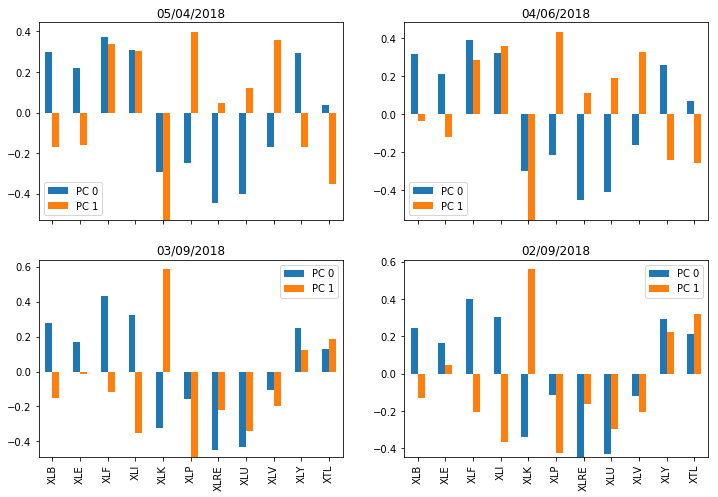

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt

# plotStack is the subset of PCA's that will be plotted
plotStack = pl_stack[0:4]
numRows = int(len(plotStack)/2)

# Create a figure (collection of axes, one per plot, arranged in rows and columns)
fig, axes = plt.subplots(nrows=numRows, ncols=2, sharex=True)

# Set height, width (in inches) of figure
fig.set_figheight(numRows * 4)
fig.set_figwidth(12)

plotNum = 0

# Plot the PCA's
for stk in plotStack :
    suffix = stk[0].strftime("%Y%m%d")
    pca_df = stk[1]
    
    print("Stack {} shape: {}".format(stk[0], stk[1].shape))
    
    # Plot the first 2 PC's
    s_df = pca_df.loc[:, idx[ ["PC 0", "PC 1"],:]].stack()
    s_df.index = s_df.index.droplevel(0)
    # s_df
    
    ax0, ax1 = int(plotNum/2), (plotNum % 2)
    # print("({}, {})".format(ax0, ax1))
    s_df.plot.bar(ax=axes[ ax0, ax1 ])
    axes[ax0,ax1].set_title(stk[0].strftime("%m/%d/%Y"))
    plotNum += 1
    #gd.save_data(data, "sector_residuals_{}.pkl".format(suffix))
    

## Examine one PCA

datetime.datetime(2017, 4, 7, 0, 0)

PC 0      PC 1
Dt                                 
2017-04-07 XLB   0.253081 -0.230110
           XLE   0.158183  0.148760
           XLF   0.447972 -0.100767
           XLI   0.313234 -0.266240
           XLK  -0.339206 -0.118119
           XLP  -0.441004  0.060157
           XLRE -0.322772 -0.127406
           XLU  -0.409992  0.113408
           XLV   0.116681  0.559496
           XLY  -0.109280 -0.567968
           XTL  -0.068974 -0.401987

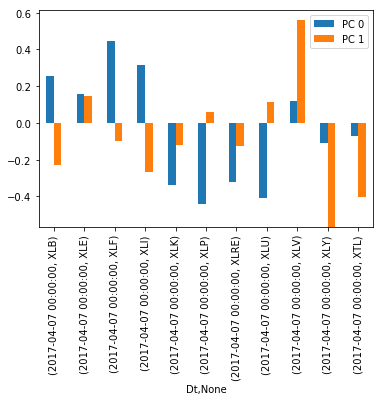

In [38]:
label, pca_df = pl_stack[14]
label
s_df = pca_df.loc[:, idx[ ["PC 0", "PC 1"],:]].stack()
s_df
s_df.plot.bar()

In [39]:
u_df = pca_df.loc[ :, idx[ ["PC 0", "PC 1"], :]].unstack(level=1)
u_df.index
u_df = u_df.reset_index()
u_df["ticker"] = u_df["level_1"].astype("category")
u_df["PC num"] = u_df["level_0"].astype("category")
u_df


MultiIndex(levels=[['Explained Var', 'Explained Var Ratio', 'PC 0', 'PC 1'], [0, 1, 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'XTL'], [2017-04-07 00:00:00]],
           labels=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
           names=[None, None, 'Dt'])

,level_0,level_1,Dt,0,ticker,PC num
0,PC 0,XLB,2017-04-07,0.253081,XLB,PC 0
1,PC 0,XLE,2017-04-07,0.158183,XLE,PC 0
2,PC 0,XLF,2017-04-07,0.447972,XLF,PC 0
3,PC 0,XLI,2017-04-07,0.313234,XLI,PC 0
4,PC 0,XLK,2017-04-07,-0.339206,XLK,PC 0
5,PC 0,XLP,2017-04-07,-0.441004,XLP,PC 0
6,PC 0,XLRE,2017-04-07,-0.322772,XLRE,PC 0
7,PC 0,XLU,2017-04-07,-0.409992,XLU,PC 0
8,PC 0,XLV,2017-04-07,0.116681,XLV,PC 0
9,PC 0,XLY,2017-04-07,-0.109280,XLY,PC 0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


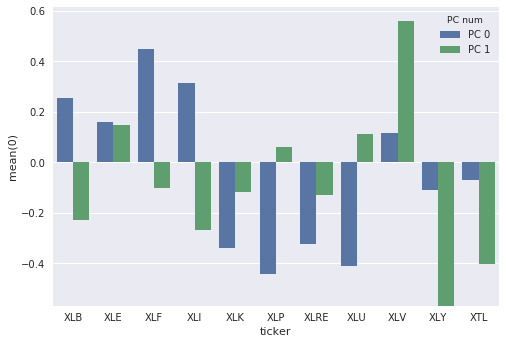

In [40]:

import seaborn as sns

sns.barplot(x="ticker", hue="PC num", y=0,  data=u_df)